# Specific Test III. Learning Mass of Dark Matter Halo 

__Task:__ Using the provided dataset implement a regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass. You can use the machine learning algorithm of your choice.  Please implement your approach in PyTorch or Keras and discuss your strategy.	

__Dataset:__ https://drive.google.com/file/d/1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j/view

__Dataset Description:__ The data set consists of strong lensing images for cold dark matter with subhalo substructure. For each lensing image the corresponding fraction of mass in dark matter substructure is provided.

__Evaluation Metrics:__ MSE (mean squared error)

The first step is to load the dataset and explore it briefly. This experiment is performed on Google Colab so we have to mount the Google Drive first. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/gsoc

/content/gdrive/My Drive/gsoc


In [ ]:
!ls

Common_test1_Multi_Class_Classification.ipynb
dataset
__MACOSX
regression_dataset
Specific_test_2_Regression_test.ipynb
trained_models


Let's unzip the data 

In [ ]:
# only run first time
# import tarfile
# import os
# PATH=os.getcwd()

# with tarfile.open(PATH+'/regression_dataset/'+'lens_data_alt.tgz', 'r:gz') as tar:
#     tar.extractall(PATH+'/regression_dataset/')

In [ ]:
!ls regression_dataset

lens_data  lens_data_alt.tgz


Import dependencies.

In [ ]:
from PIL import Image
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# initial setup 
# set random seed
np.random.seed(42)
torch.manual_seed(42)

# set matplotlib 
%matplotlib inline
sns.set_style('darkgrid')

Ok!!! Now we should set the device we want to use to train our deep learning model.

In [ ]:
# using mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
# using CUDA 
elif torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)  
# using CPU 
else:
    print ("GPU not available.")
    device=torch.device("cpu")

tensor([1.], device='cuda:0')


## Data preprocessing:

First, let's see a few images from our dataset.

In [ ]:
# get the current directory 
PATH=os.getcwd()

In [ ]:
PATH

'/content/gdrive/My Drive/gsoc'

Let's see one image

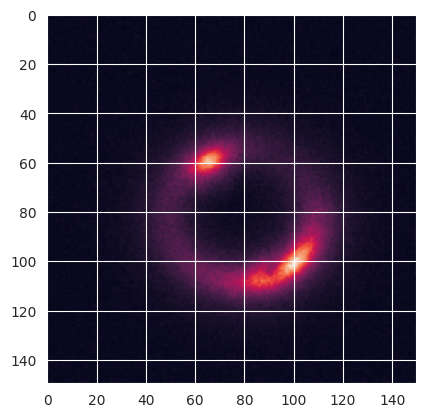

In [ ]:
p=PATH+"/regression_dataset/lens_data/image_15524987064700608483353838948967561.npy"
image_data = np.load(p,allow_pickle=True)

# Plot the image
plt.imshow(image_data[0])
plt.show()

Let's see some more images

In [ ]:
# first 9 images in the folder
files=os.listdir(PATH+"/regression_dataset/lens_data")

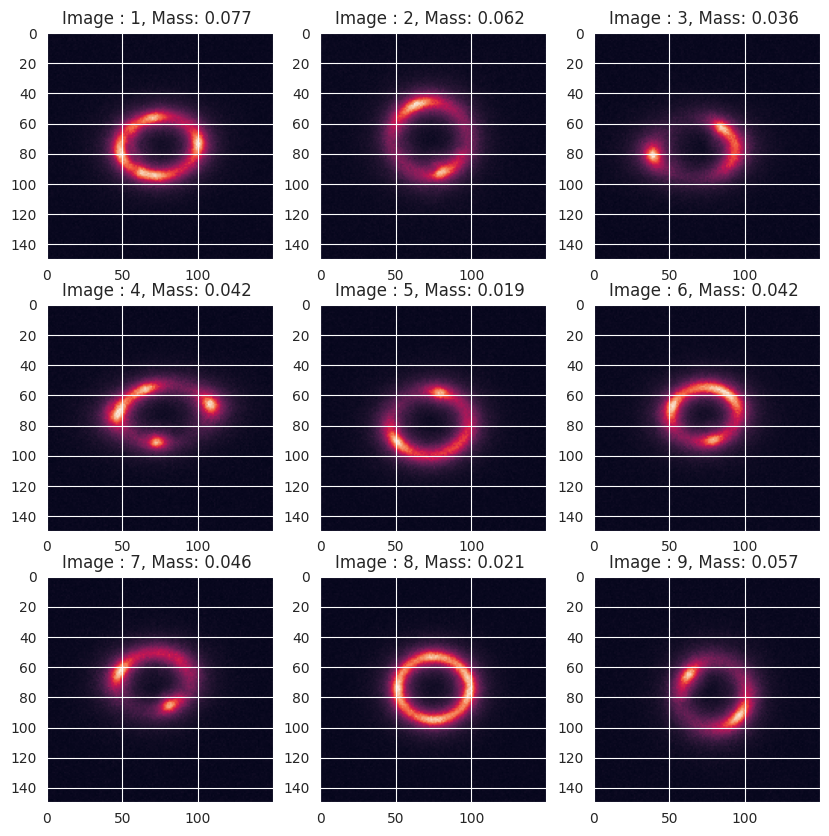

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))

# plot each image in a subplot
n=0
for i in range(3):
    for j in range(3):
        image_data = np.load(PATH+"/regression_dataset/lens_data/"+files[n],allow_pickle=True)
        axs[i,j].imshow(image_data[0])
        axs[i,j].set_title(f"Image : {n+1}, Mass: {image_data[1]:0.3f} ")
        n+=1
    
# show the figure
plt.show()

Seeing the images above, we can think of some image transforms that can be beneficial in our case for creating a better model.

Let's define the transforms we want to apply to our input images. For our baseline model, we apply some basic image transforms. The `Resize` transform will just resize our image to a custom size. Resizing the image can help us in making training faster since the network has to process smaller images now. And `ToTensor` transform will convert our input image into tensors. Since the data is already normalized, we do not need to apply the `Normalize` transform.

In [ ]:
# image should be what size
IMG_SIZE=(64,64)

image_transforms = {
    "train": transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Resize(IMG_SIZE)
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(IMG_SIZE)])
        }

### Creating Dataset class:
 
In PyTorch, the `Dataset` class is used to define a custom dataset. A dataset is typically used to load and preprocess the data used for training or testing a machine learning model. There are two main functions that we want to implement in this class:

- `__len__` function: The `__len__()` method returns the number of samples in the dataset, which is the length of the `samples` list.
- `__getitem__` function: The `__getitem__()` method loads the image from the file path specified in `samples`, performs the required transforms and return the image and the label associated with it.

In our case, we load an image file from the memory which contains the image data and the mass associated with it. After loading, we simply return the image and the target value.

In [ ]:
class LenseImageDataset(datasets.VisionDataset):
    
    def __init__(self,img_dir, max_samples=1000, transform=None,target_transform=None, limit=False):
        
        """
        Parameters:
        img_dir: path of the directory where the dataset is present. 
                Something like './dataset/train'
                
        transform: transform to be applied on the data.
        
        target_transform: transform to be applied to the target label.
        """
        
        self.root=img_dir
        self.transform=transform
        self.target_transform=target_transform

        files=os.listdir(self.root)

        self.samples=[ (idx, name) for idx, name in enumerate(files)]
    
    def __len__(self):
        
        return len(self.samples)

    def __getitem__(self, idx):
        
        # get the image path and it's corresponding index
        sample_idx, img_path = self.samples[idx]
#         print(img_path,class_idx)
        
        # load the image data
        img_data= np.load(self.root+"/"+img_path,allow_pickle=True)

        # get the image and the associated mass
        img=img_data[0]
        mass=img_data[1]

        # print for debugging 
        # print(img_path)
        # print(mass)
        # plt.imshow(img) 
        # plt.show()
        
        # perform transform 
        if self.transform is not None:
            img = self.transform(img)

        return img, mass

Ok! Now let's create our training and testing datasets.

In [ ]:
# getting data 
training_data=LenseImageDataset(
    img_dir=PATH+"/regression_dataset/lens_data",
    transform=image_transforms["train"],
)
testing_data=LenseImageDataset(
    img_dir=PATH+"/regression_dataset/lens_data",
    transform=image_transforms["test"],
    )

Now, let's partition the dataset into training and testing set. Here, we use 90% of the data for training and 10% of the data for validation.

In [ ]:
# Create a list of indices (e.g. for a dataset)
indices = list(range(len(training_data)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42)

# get training and test subset  
training_data = Subset(training_data, train_indices)
testing_data = Subset(testing_data, val_indices)

### Creating Dataloaders:

In PyTorch, `DataLoader` is a class that provides an iterable over a dataset. It is used to load the data in batches during the training and evaluation of machine learning models.

So, let's create our dataloaders.

In [ ]:
# BATCH_SIZE
BATCH_SIZE=128

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

# trying to see if we have the right size
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([128, 1, 64, 64])
Labels batch shape: torch.Size([128])


What do our target values look like?

In [ ]:
train_labels

tensor([0.0378, 0.0292, 0.0248, 0.0402, 0.0175, 0.0343, 0.0450, 0.0368, 0.0181,
        0.0589, 0.0571, 0.0422, 0.0916, 0.0559, 0.0297, 0.0425, 0.0466, 0.0377,
        0.0225, 0.0466, 0.0641, 0.0446, 0.0190, 0.0334, 0.0618, 0.0368, 0.0281,
        0.0440, 0.0357, 0.0313, 0.0252, 0.0652, 0.0312, 0.0305, 0.0306, 0.0296,
        0.0376, 0.0432, 0.0262, 0.0240, 0.0320, 0.0574, 0.0256, 0.0297, 0.0367,
        0.0324, 0.0342, 0.0196, 0.0411, 0.0310, 0.0352, 0.0362, 0.0438, 0.0612,
        0.0308, 0.0272, 0.0366, 0.0211, 0.0352, 0.0501, 0.0349, 0.0441, 0.0257,
        0.0349, 0.0454, 0.0395, 0.0470, 0.0447, 0.0421, 0.0660, 0.0268, 0.0664,
        0.0564, 0.0588, 0.0229, 0.0499, 0.0496, 0.0258, 0.0419, 0.0442, 0.0643,
        0.0499, 0.0682, 0.0331, 0.0605, 0.0522, 0.0459, 0.0611, 0.0443, 0.0432,
        0.0348, 0.0296, 0.0399, 0.0448, 0.0435, 0.0530, 0.0222, 0.0218, 0.0443,
        0.0399, 0.0585, 0.0394, 0.0468, 0.0420, 0.0571, 0.0387, 0.0210, 0.0367,
        0.0410, 0.0633, 0.0263, 0.0381, 

## Model Training:

Now that we have completed all our data preprocessing. We can move towards training our model and then evaluating it's performance. 

The first step in the training process is to define the model architecture. For this, we are going to utlize transfer learning.

Transfer learning is a technique in machine learning and deep learning where a pre-trained model is used as a starting point for a new task instead of training a model from scratch.

In our case, we are going to use the `ResNet18` architecture to create our image regressor model. This allows us to get high performance on a task without the headache of training a model from scratch.

Let's load the pretrained model.

### Define model architecture:

In [ ]:
class ResNetGray(nn.Module):
    def __init__(self, out=1):
        super(ResNetGray, self).__init__()
        
        # Load the pre-trained ResNet model
        self.resnet = resnet18(pretrained=True)
        
        # Modify the first convolutional layer to accept one channel as input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Replace the fully connected layer with a new one that matches the number of classes in our problem
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, out)
        
    def forward(self, x):
        return self.resnet(x)

In [ ]:
model = ResNetGray()
model = model.to(device)
summary(model, (1,64,64))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

### Training helper functions:

Let's define a helper function to take care of the training. 

In [ ]:
# Write a method called `train_one_epoch` that runs one step using the optimizer.
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch, batch_size):
    model.train()
    losses = []
    counter = []
    num_correct=0
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        img=img.float()
        label=label.float()

        # ------------------
        # forward pass
        output=model(img)
        # print(label)

        # calculate loss 
        loss= F.mse_loss(output.squeeze(),label)
        
        #zero all gradients
        optimizer.zero_grad()
        
        #do a backward pass
        loss.backward()
        
        #update weights
        optimizer.step()
        # print(loss)
        
        # ------------------
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append((i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))


    return losses, counter

Another helper function for the evaluation

In [ ]:
# let's create a method called `test_one_epoch` that evalutes the trained model on the test dataset. 
# Return the average test loss and the number of samples that the model predicts correctly.

def test_one_epoch(test_loader, model, device):

    # put model in evaluation mode
    model.eval()

    # initialize variables
    test_loss = 0
    counter=0

    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            img=img.float()
            label=label.float()
            
            # ------------------
            output = model(img)
            counter+=1
            # print(output.shape,label.shape)
            test_loss += F.mse_loss(output.squeeze(),label).item() # loss function goes here

            # ------------------

    test_loss /= len(test_loader.dataset)

    return test_loss

### Training the model

In [ ]:
# Hyperparameters 
log_interval = 10
max_epochs= 10
lr=3e-3 #this is the maximum learning rate I should use

In [ ]:
# initialize model again 
model = ResNetGray()
model = model.to(device)

Initialize optimizer

In [ ]:
# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

We can also try a learning rate scheduler to get a decaying learning rate as the training goes on. 

In [ ]:
# Define your learning rate schedule
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

Finally let's train the model 

In [ ]:
# initialize lists to store losses
train_losses = []
train_counter = []
test_losses = []


for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    epoch_start=time.time()

    # train one epoch
    train_loss, counter= train_one_epoch(train_dataloader, 
                                          model,
                                          device,
                                          optimizer,
                                          log_interval,
                                          epoch,
                                          BATCH_SIZE,
                                          )
    
    # test one epoch
    test_loss= test_one_epoch(test_dataloader, 
                              model,
                              device)
    
    print(f'Time taken for the epoch:{time.time()-epoch_start}')

    # learning rate step
    # lr_scheduler.step()

    # Record results
    print("--"*20)
    print(f"Training loss for epoch {epoch+1} :{train_loss[0]}")
    print(f"Testing loss for epoch {epoch+1} : {test_loss}")
    
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)


print("\n")
print(f"Train loss: {train_losses[-1]/len(train_dataloader.dataset):0.8f}") 
print(f"Test loss: {test_losses[-1]/len(test_dataloader.dataset)}")

Epochs:  10%|█         | 1/10 [00:20<03:00, 20.10s/it]

Time taken for the epoch:20.103374481201172
----------------------------------------
Training loss for epoch 1 :0.14318859577178955
Testing loss for epoch 1 : 6.345697950697347e-06


Epochs:  20%|██        | 2/10 [00:40<02:40, 20.01s/it]

Time taken for the epoch:19.94492769241333
----------------------------------------
Training loss for epoch 2 :0.0008081865962594748
Testing loss for epoch 2 : 2.881460214881331e-06


Epochs:  30%|███       | 3/10 [00:59<02:18, 19.79s/it]

Time taken for the epoch:19.51145625114441
----------------------------------------
Training loss for epoch 3 :0.00026211680960841477
Testing loss for epoch 3 : 2.000528927944768e-06


Epochs:  40%|████      | 4/10 [01:19<01:58, 19.71s/it]

Time taken for the epoch:19.58284044265747
----------------------------------------
Training loss for epoch 4 :0.00023832518490962684
Testing loss for epoch 4 : 1.9289779619397492e-06


Epochs:  50%|█████     | 5/10 [01:38<01:38, 19.67s/it]

Time taken for the epoch:19.59937071800232
----------------------------------------
Training loss for epoch 5 :0.0002255849540233612
Testing loss for epoch 5 : 1.7512992241555887e-06


Epochs:  60%|██████    | 6/10 [01:57<01:18, 19.52s/it]

Time taken for the epoch:19.21900749206543
----------------------------------------
Training loss for epoch 6 :0.0002650694805197418
Testing loss for epoch 6 : 1.7959751572009971e-06


Epochs:  70%|███████   | 7/10 [02:18<00:59, 19.69s/it]

Time taken for the epoch:20.035876274108887
----------------------------------------
Training loss for epoch 7 :0.00024805183056741953
Testing loss for epoch 7 : 1.6397692745792146e-06


Epochs:  80%|████████  | 8/10 [02:37<00:39, 19.64s/it]

Time taken for the epoch:19.540138006210327
----------------------------------------
Training loss for epoch 8 :0.00023971994232852012
Testing loss for epoch 8 : 1.680479810724893e-06


Epochs:  90%|█████████ | 9/10 [02:57<00:19, 19.80s/it]

Time taken for the epoch:20.15029239654541
----------------------------------------
Training loss for epoch 9 :0.00020747425151057541
Testing loss for epoch 9 : 1.6396240824362618e-06


Epochs: 100%|██████████| 10/10 [03:17<00:00, 19.73s/it]

Time taken for the epoch:19.565702438354492
----------------------------------------
Training loss for epoch 10 :0.00033029826590791345
Testing loss for epoch 10 : 2.0545841916725875e-06


Train loss: 0.00000003
Test loss: 2.3085215636770645e-09


We can see what output our model generates on a given image.

In [ ]:
train_features=train_features.to(device)
train_labels=train_labels.to(device)

print(f"Prediction:{model(train_features.float())[3].item()}")
print(f"Actual:{train_labels[3].item()}")

Prediction:0.04500783234834671
Actual:0.040203596009150244


Save the model

In [ ]:
# save the model for inference later
torch.save(model.state_dict(),PATH +"/trained_models/resnet18_10epochs.pt")

### Loss curve 

Finally, let's see what the loss curve looks like during the training of the neural network. 

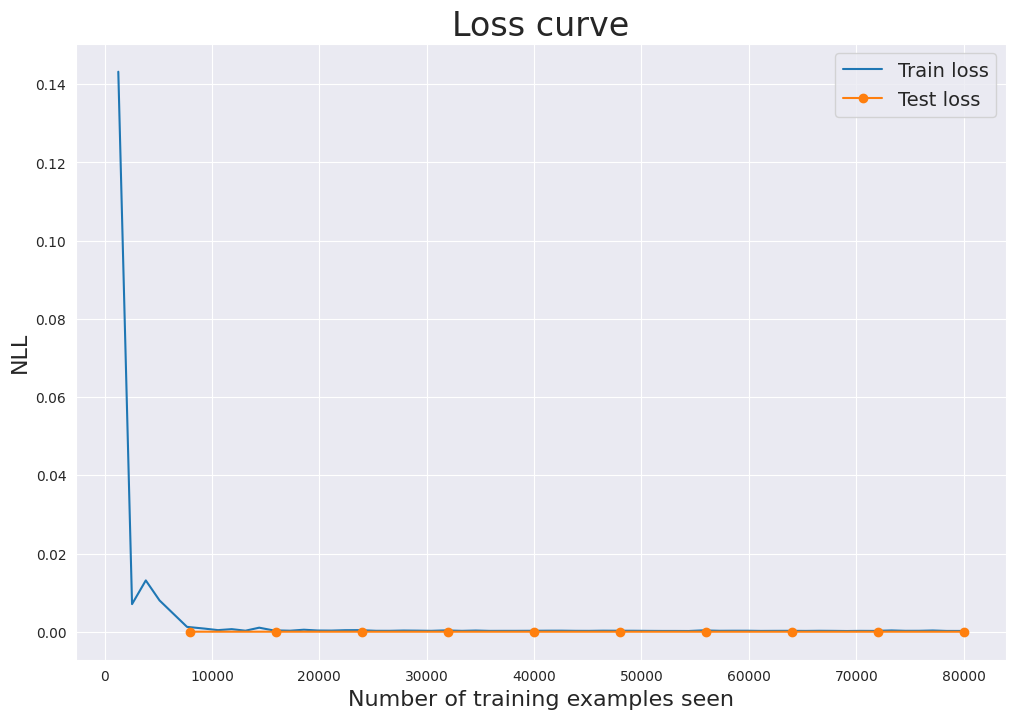

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_dataloader.dataset) for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

## Conclusion:

In this notebook, an image regression algorithm is presented to learn the mapping between lensing images and the lensing dark matter halo mass. 

To create our image regression model, we use the ResNet18 pretrained model and fine-tuned it on our dataset. Following are of the hyperparameters we used:
- __Image size__: (64,64)
- __Batch size:__ 128
- __Epochs:__ 10
- __Learning rate:__ 3e-3 
- __Optimizer:__ Adam

__Results__:
1. __Training MSE__: 3e-8
2. __Testing MSE:__ 2.30852e-09

From the above results, we can see that our image regression model performs very well on the training set as well as the testing set. It can accurately predict the mass of the dark matter halo. 